In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.4.0
Keras version 2.4.3
/device:GPU:0
Found GPU at: /device:GPU:0


#***Division of the Dataset***

In [ ]:
!pip install split-folders tqdm

In [ ]:
import splitfolders
import os
from google.colab import drive
drive.mount('/content/drive')


datadir='/content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_images'
datasplit='/content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_splitten'

#split with the ratio of 0.8 for training set, 0.1 for validation set, 0.1 for test set.
splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_images", output="/content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_splitten", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values


Copying files: 0 files [00:00, ? files/s]

Mounted at /content/drive


Copying files: 8745 files [45:52,  3.18 files/s]


# ***Load Data***

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

import os
from google.colab import drive
drive.mount('/content/drive')

datadir = '/content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_splitten'
trainingset = datadir+'/train'
testset = datadir+'/test'
valset = datadir+'/val'

batch_size = 32
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

val_datagen = ImageDataGenerator(
    rescale = 1. / 255)

val_generator = val_datagen.flow_from_directory(
    directory=valset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples_train = train_generator.n
num_samples_val = val_generator.n
num_samples_test = test_generator.n


num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples_train,num_classes))
print('Loaded %d validating samples from %d classes.' %(num_samples_val,val_generator.num_classes))
print('Loaded %d test samples from %d classes.' %(num_samples_test,test_generator.num_classes))


Mounted at /content/drive
Found 6992 images belonging to 8 classes.
Found 871 images belonging to 8 classes.
Found 882 images belonging to 8 classes.
Image input (118, 224, 3)
Classes: ['Dust_Mops_&_Pads', 'Figs', 'Nuts_snacks', 'Seltzer_Water', 'food_tray', 'fruit_plate', 'instant_Soup', 'plastic_knife']
Loaded 6992 training samples from 8 classes.
Loaded 871 validating samples from 8 classes.
Loaded 882 test samples from 8 classes.


#***Show random images***

Figs


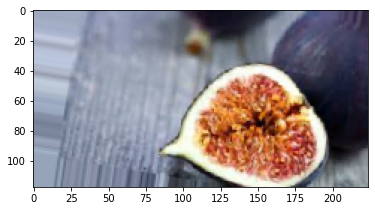

Figs


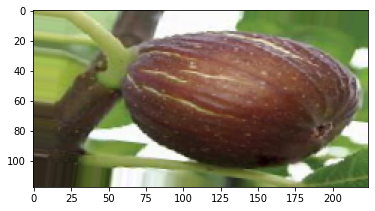

plastic_knife


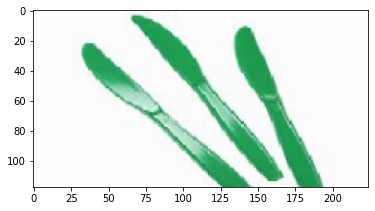

In [ ]:
import matplotlib.pyplot as plt

n=3

x,y = train_generator.next()

for i in range(0,n):
  image=x[i]
  label=y[i].argmax()
  print(classnames[label])
  plt.imshow(image)
  plt.show()
  

#***AlexNet***

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

def AlexNett(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model
 
# create the model
model = AlexNett(input_shape,num_classes)
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0

#***Load a trained model***

In [ ]:
import os
from keras.models import load_model

models_dir = datadir + '/models/'

def loadmodel(problem):
  filename = os.path.join(models_dir, '%s.h5' %problem)
  try:
    model=load_model(filename)
    print("\nModel loaded successfully from file %s \n" %filename)
  except OSError:
    print("\nModel file %s not found!!! \n" %filename)
    model=None
  return model

model = loadmodel('AlexNet_10_epochs')


Model loaded successfully from file /content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_splitten/models/AlexNet_10_epochs.h5 



#***Train***

In [ ]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=val_generator.n//val_generator.batch_size+1
epochs = 100
try:
    history = model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=val_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


Epoch 1/100
218/218 [==============================] - 1801s 8s/step - loss: 3.0938 - accuracy: 0.2194 - val_loss: 2.8585 - val_accuracy: 0.1343
Epoch 2/100
218/218 [==============================] - 57s 259ms/step - loss: 2.8586 - accuracy: 0.2732 - val_loss: 2.5513 - val_accuracy: 0.3180
Epoch 3/100
218/218 [==============================] - 57s 263ms/step - loss: 2.6974 - accuracy: 0.3115 - val_loss: 2.4289 - val_accuracy: 0.3766
Epoch 4/100
218/218 [==============================] - 59s 271ms/step - loss: 2.5571 - accuracy: 0.3406 - val_loss: 3.7356 - val_accuracy: 0.3077
Epoch 5/100
218/218 [==============================] - 59s 268ms/step - loss: 2.4594 - accuracy: 0.3642 - val_loss: 2.1730 - val_accuracy: 0.4133
Epoch 6/100
218/218 [==============================] - 59s 270ms/step - loss: 2.3217 - accuracy: 0.4114 - val_loss: 2.7819 - val_accuracy: 0.3972
Epoch 7/100
218/218 [==============================] - 59s 269ms/step - loss: 2.2844 - accuracy: 0.4193 - val_loss: 2.7939 - 

***Save the model***

In [ ]:
import os

models_dir = datadir + '/models/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(model,'AlexNet_100_epochs')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/ML_homework_2/Dataset_splitten/models/AlexNet_50_epochs.h5



#***Evaluate the model***

In [ ]:
val_steps = test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate(test_generator, verbose=1, steps=val_steps)
print('Test Loss: %f' %loss)
print('Test Accuracy: %f' %acc)

28/28 [==============================] - 183s 7s/step - loss: 1.7607 - accuracy: 0.6621
Test Loss: 1.760738
Test Accuracy: 0.662132


***Precision, Recall, F-score***

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


Found 882 images belonging to 8 classes.
28/28 [==============================] - 2s 74ms/step
                  precision    recall  f1-score   support

Dust_Mops_&_Pads      0.464     0.441     0.452       102
            Figs      0.531     0.566     0.548       106
     Nuts_snacks      0.818     0.077     0.141       117
   Seltzer_Water      0.452     0.345     0.392       110
       food_tray      0.283     0.387     0.327       111
     fruit_plate      0.172     0.123     0.144       122
    instant_Soup      0.312     0.785     0.447       107
   plastic_knife      0.638     0.411     0.500       107

        accuracy                          0.383       882
       macro avg      0.459     0.392     0.369       882
    weighted avg      0.457     0.383     0.362       882



***Confusion matrix analysis***

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))


Found 882 images belonging to 8 classes.
 1/28 [>.............................] - ETA: 2s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


28/28 [==============================] - 2s 75ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Nuts_snacks      ->  instant_Soup      	51 	5.78 % 
fruit_plate      ->  instant_Soup      	45 	5.10 % 
Seltzer_Water    ->  instant_Soup      	36 	4.08 % 
fruit_plate      ->  food_tray         	30 	3.40 % 
Nuts_snacks      ->  food_tray         	27 	3.06 % 
plastic_knife    ->  Dust_Mops_&_Pads  	25 	2.83 % 
Dust_Mops_&_Pads ->  instant_Soup      	18 	2.04 % 
Nuts_snacks      ->  fruit_plate       	18 	2.04 % 
food_tray        ->  fruit_plate       	18 	2.04 % 
food_tray        ->  instant_Soup      	14 	1.59 % 
food_tray        ->  Figs              	14 	1.59 % 
Figs             ->  fruit_plate       	13 	1.47 % 
Figs             ->  food_tray         	13 	1.47 % 
Figs             ->  instant_Soup      	12 	1.36 % 
Dust_Mops_&_Pads ->  food_tray         	12 	1.36 % 
food_tray        ->  Seltzer_Water     	12 	

#***CONFUSION MATRIX***

In [ ]:
import numpy as np
import pandas as pd
import random
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import *
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn import tree
from sklearn import svm

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=plt.cm.Blues):
  if not title:
    if normalize:
      title = 'Normalized confusion matrix'
    else:
      title = 'Confusion matrix, no normalization'
  cm = confusion_matrix(y_true, y_pred)
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    
  else:
    pass
    
  
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)

  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title=title, ylabel='true label', xlabel='predicted label')
  

  ax.set_ylim(len(classes)-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  

  fmt= '.2f' if normalize else 'd'
  thresh=cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j]>thresh else "black")
  fig.tight_layout()
  return ax


print('Libraries imported.')

Libraries imported.


[[45  4  0 11 12  7 18  5]
 [ 0 60  0  0 13 13 12  8]
 [ 3  8  9  1 27 18 51  0]
 [11  9  0 38 10  4 36  2]
 [ 3 14  1 12 43 18 14  6]
 [ 7  9  1 11 30 15 45  4]
 [ 3  3  0  2  9  6 84  0]
 [25  6  0  9  8  6  9 44]]


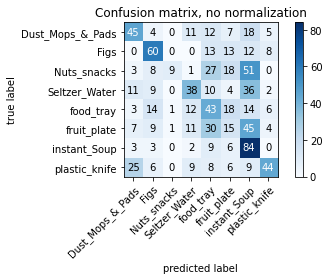

In [ ]:
#CONFUSION MATRIX
cm= confusion_matrix(Ytest, Ypred, labels=None, sample_weight=None)
print(cm)
plot_confusion_matrix(Ytest, Ypred, classnames, normalize=False)

#***Plot results***

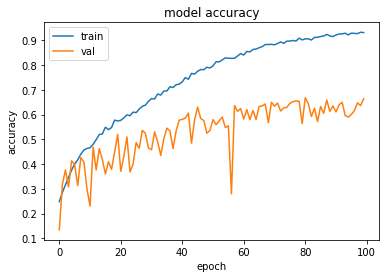

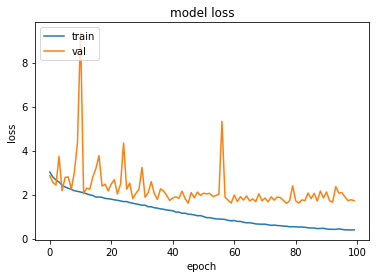

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()